# Clustering

## Dimensionality Reduction & LSA
#### Dataset
- **Altitude** - Altitude.MSL.Single Value
- **Distance** - Relative Position.Distance.Nautical Miles
- **Report** - combined narrative and summary stemmed
- **Narrative**
- **Summary**

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import json as js
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from sklearn import metrics
import scipy.cluster.hierarchy as hierarchy 
%matplotlib inline

In [2]:
# Read report
report = pd.read_csv("02-ASRS-stemmed.csv", index_col=0)
report.head()

,Altitude,Distance,Narrative,Report,Summary
0,2500,9.0,F/O FLYING ACFT FROM LEFT SEAT. BLUE AND WHITE...,helicopt encount sma acft IN see avoid situat ...,HELICOPTER ENCOUNTERED SMA ACFT IN SEE AND AVO...
1,4500,22.0,WHILE LEVEL AT 4500'; HDG 246 DEGS ON VICTOR 1...,close prox ga-sma ga-smt ON v106 . level AT 45...,CLOSE PROX GA-SMA GA-SMT ON V106.
2,800,2.0,I WAS INVOLVED IN A NMAC WHILE ON FINAL APCH T...,close prox 2 ga-sma acft IN traffic pattern AT...,CLOSE PROX 2 GA-SMA ACFT IN TRAFFIC PATTERN AT...
3,3500,15.0,WHILE ON CROSS-COUNTRY VFR FROM ORANGE; MA TO ...,close prox GA sma parachutist IN restrict area...,CLOSE PROX GA SMA AND PARACHUTIST IN RESTRICTE...
4,1800,2.0,UPON REACHING MADISON VOR WE REQUESTED CLRNC D...,standard separaton nmac between commut sma acf...,LESS THAN STANDARD SEPARATON AND NMAC BETWEEN ...


In [3]:
# Word reference lookup helper
word_reference = pd.read_csv("02-ASRS-word-reference.csv", index_col=0)
def lookup(word):
    for i in range(len(word_reference)):
        if word_reference['after'][i] == word:
            print(word_reference['before'][i])
            break

lookup('ra')

RAs


In [4]:
# Tfid Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df=4, max_df=0.8)
dtm = vectorizer.fit_transform(report['Report'])
print(dtm.shape)
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
terms = vectorizer.get_feature_names()

(571, 1600)


In [5]:
# Decide n_components
svd = TruncatedSVD(n_components=100, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

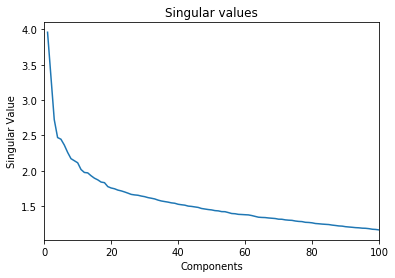

In [6]:
s = svd.singular_values_
plt.xlim([0,100])
plt.plot(range(1,len(s)+1),s)
plt.title('Singular values')
plt.ylabel('Singular Value')
plt.xlabel('Components')

In [7]:
svd = TruncatedSVD(n_components=20, algorithm="randomized")
svd_fit = svd.fit_transform(centered_dtm)
svd_norm = Normalizer().fit_transform(svd_fit)

vt = svd.components_
dfnorm = pd.DataFrame(svd_norm)

In [8]:
order_components = vt.argsort()[:, ::-1]
components = []
for i in range(vt.shape[0]):
    label = [terms[ind] for ind in order_components[i, :10]]
    components.append(' '.join(label))
dfnorm.columns = components

In [9]:
dfloc = pd.DataFrame(scale(report[['Distance', 'Altitude']]), columns=['Distance', 'Altitude'])
df_features = dfloc.join(dfnorm)
df_features.to_csv('03-lsa.csv')
df_features.head()

,Distance,Altitude,tcasii ft ra clb tfc atc dscnt visual acr ta,acr sector radar issu ctlr separ error hold sep zbw,acr twr rwi turn apch downwind deg tcasii final hdg,aircraft traffic tower acr runway approach pilot ra downwind flight,sma smt hdg deg apch clock vfr atc tca 12,sma ra rptr tcasii pattern acft acr radar final reveal,apch il ctl ra pvd vector rwi aircraft bdl tower,ft sma acr 10000 mht 9000 4000 3000 class glider,...,deg hdg tcasii airspac class mht ra glider sma ash,smt rptr twr dep tcasii depart ra ash mlt ft,smt b737 pattern dscnt alt glider mlt mht pvd clb,alt tfc pvd assign sector pattern hold atc downwind atx,twr pvd 9000 11000 10000 mlt ltt twin target contact,b737 vfr smt issu twr mht atx tfc clock rpted,sector smt ft new radar pvd twin approx york po,dep mht rwi class downwind airspac smt po depart boston,mlg mht tca lgt rptr final tfc bo boston deg,rptr tca pvd bdl 10000 clb conflict atx tfc separ
0,-0.214551,-0.640337,-0.359090,-0.087764,-0.080596,-0.002407,0.529482,0.436986,-0.174764,0.082637,...,0.173925,-0.389862,0.018177,-0.008743,0.013278,-0.136498,-0.004684,-0.004342,-0.162262,0.015257
1,0.237947,-0.373952,-0.313446,0.057067,-0.010736,-0.172097,0.712124,-0.102539,-0.048931,-0.245862,...,0.038526,0.215080,0.274411,-0.169650,-0.175030,0.098390,0.115715,-0.188489,0.024961,0.137386
2,-0.458203,-0.866764,-0.549950,-0.302304,0.135273,-0.012957,0.010639,0.473413,-0.164469,-0.091544,...,-0.028458,-0.352207,0.104244,-0.041338,-0.233458,-0.176926,0.032615,-0.103954,0.093540,-0.111925
3,-0.005706,-0.507144,-0.516192,-0.029402,-0.422871,0.212272,0.198130,0.229709,-0.026929,0.375069,...,0.372670,0.122616,-0.106081,0.066450,0.142074,-0.173301,-0.083888,0.020156,0.028494,-0.053203
4,-0.458203,-0.733571,-0.458644,-0.202060,0.293867,-0.344618,0.110612,-0.045308,-0.033796,-0.237918,...,0.047881,0.121178,-0.225075,0.175140,0.282807,0.069283,0.239739,-0.216572,0.010588,0.415225


## Clustering

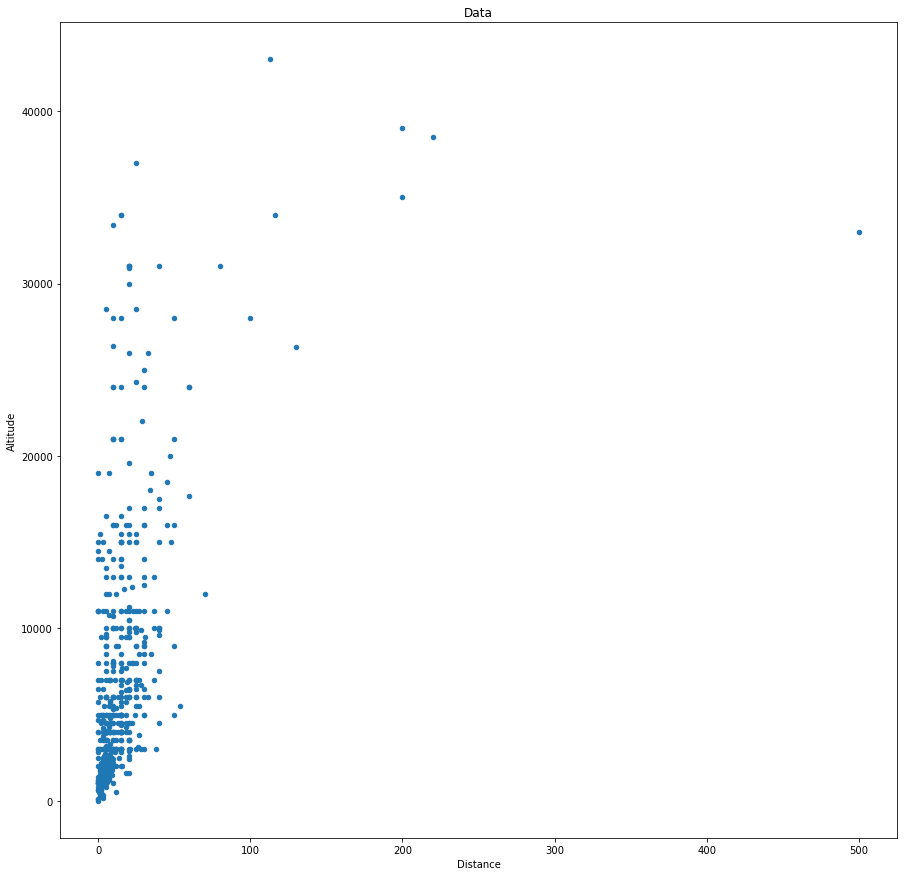

In [10]:
# Plot the entire dataset
plt.figure(figsize=(15, 15))

dis = report['Distance']
alt = report['Altitude']
plt.scatter(x=dis, y=alt, s=20)
    
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('Data')
plt.show()

## K-means++

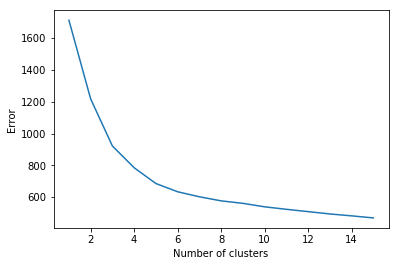

In [11]:
# Use the k-mean++ algorithm to find cluster
# Find out the optimal number of clusters 
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    plt.show()
    
evaluate_clusters(df_features, 15)

From the graph above, we can see that the error reach below 800 after 6 clusters and does not have a huge change after this number. Therefore, we choose 5 as the optimal number of clusters.

In [12]:
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1)
kmeans.fit_predict(df_features)
Kcentroids = kmeans.cluster_centers_
Klabels = kmeans.labels_
Kerror = kmeans.inertia_
print("The total error of the clustering is: {}.".format(Kerror))

The total error of the clustering is: 719.641566028221.


In [13]:
# Name k clusters
Kasc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
Korder_centroids = Kasc_order_centroids[:,::-1]
Korder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Korder_centroids]) # remove locations

Kcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Korder_centroids[i, :2]]
    Kcluster_names.append(label)

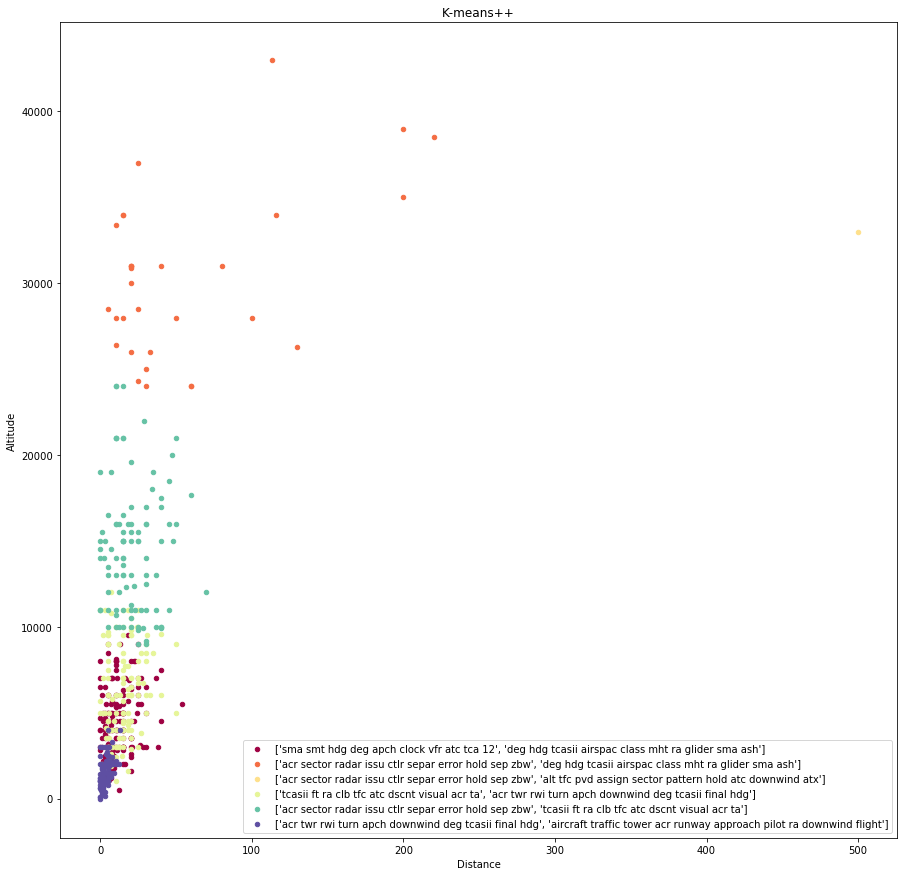

In [14]:
# Plot k-means++
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [report.iloc[i]['Distance'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    alt = [report.iloc[i]['Altitude'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, color=colors[cluster_index], label = Kcluster_names[cluster_index], s=20)
    
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('K-means++')
plt.show()

In [15]:
# Find report helper
def find_report(cluster_num):
    report = [report.iloc[i]['Summary'] for i in range(len(Klabels)) if Klabels[i] == cluster_num]
    return report

# Sample Report
# find_report(3)

## K-means++ Outliers

In [16]:
# Find 5 outliers for each cluster
from scipy.spatial.distance import euclidean
def remove_outliers(k, labels, centroids, names):
    new_report = report.copy()
    new_features = df_features.copy()
    for cluster_label in range(k):
        print('Cluster', cluster_label + 1, names[cluster_label])
        points = [(index, df_features.values[index][:2]) for index in range(len(labels)) if labels[index] == cluster_label] # (index, location)
        distances = [(p[0], euclidean(centroids[i][:2], p[1])) for p in points] # (index, distance)
        farthest5 = sorted(distances, key=lambda d: d[1], reverse=True)[:6]
        for point in farthest5:
            row = new_report.loc[point[0]]
            print('row {}'.format(point[0]))
            new_features = new_features.drop(point[0])
            new_report = new_report.drop(point[0])
    return new_features, new_report

# Remove outliers
result = remove_outliers(k, Klabels, Kcentroids, Kcluster_names)
new_features = result[0]
new_report = result[1]

Cluster 1 ['sma smt hdg deg apch clock vfr atc tca 12', 'deg hdg tcasii airspac class mht ra glider sma ash']
row 19
row 59
row 98
row 204
row 91
row 512
Cluster 2 ['acr sector radar issu ctlr separ error hold sep zbw', 'deg hdg tcasii airspac class mht ra glider sma ash']
row 119
row 50
row 51
row 276
row 486
row 479
Cluster 3 ['acr sector radar issu ctlr separ error hold sep zbw', 'alt tfc pvd assign sector pattern hold atc downwind atx']
row 76
Cluster 4 ['tcasii ft ra clb tfc atc dscnt visual acr ta', 'acr twr rwi turn apch downwind deg tcasii final hdg']
row 332
row 364
row 246
row 377
row 254
row 411
Cluster 5 ['acr sector radar issu ctlr separ error hold sep zbw', 'tcasii ft ra clb tfc atc dscnt visual acr ta']
row 442
row 489
row 470
row 535
row 182
row 248
Cluster 6 ['acr twr rwi turn apch downwind deg tcasii final hdg', 'aircraft traffic tower acr runway approach pilot ra downwind flight']
row 382
row 103
row 209
row 329
row 361
row 277


In [17]:
new_features['Distance'] = new_features['Distance'].apply(lambda x: x * 3)
new_features['Altitude'] = new_features['Altitude'].apply(lambda x: x * 3)
print(new_features.shape)
new_features.head()

(540, 22)


,Distance,Altitude,tcasii ft ra clb tfc atc dscnt visual acr ta,acr sector radar issu ctlr separ error hold sep zbw,acr twr rwi turn apch downwind deg tcasii final hdg,aircraft traffic tower acr runway approach pilot ra downwind flight,sma smt hdg deg apch clock vfr atc tca 12,sma ra rptr tcasii pattern acft acr radar final reveal,apch il ctl ra pvd vector rwi aircraft bdl tower,ft sma acr 10000 mht 9000 4000 3000 class glider,...,deg hdg tcasii airspac class mht ra glider sma ash,smt rptr twr dep tcasii depart ra ash mlt ft,smt b737 pattern dscnt alt glider mlt mht pvd clb,alt tfc pvd assign sector pattern hold atc downwind atx,twr pvd 9000 11000 10000 mlt ltt twin target contact,b737 vfr smt issu twr mht atx tfc clock rpted,sector smt ft new radar pvd twin approx york po,dep mht rwi class downwind airspac smt po depart boston,mlg mht tca lgt rptr final tfc bo boston deg,rptr tca pvd bdl 10000 clb conflict atx tfc separ
0,-0.643653,-1.921010,-0.359090,-0.087764,-0.080596,-0.002407,0.529482,0.436986,-0.174764,0.082637,...,0.173925,-0.389862,0.018177,-0.008743,0.013278,-0.136498,-0.004684,-0.004342,-0.162262,0.015257
1,0.713841,-1.121856,-0.313446,0.057067,-0.010736,-0.172097,0.712124,-0.102539,-0.048931,-0.245862,...,0.038526,0.215080,0.274411,-0.169650,-0.175030,0.098390,0.115715,-0.188489,0.024961,0.137386
2,-1.374610,-2.600291,-0.549950,-0.302304,0.135273,-0.012957,0.010639,0.473413,-0.164469,-0.091544,...,-0.028458,-0.352207,0.104244,-0.041338,-0.233458,-0.176926,0.032615,-0.103954,0.093540,-0.111925
3,-0.017117,-1.521433,-0.516192,-0.029402,-0.422871,0.212272,0.198130,0.229709,-0.026929,0.375069,...,0.372670,0.122616,-0.106081,0.066450,0.142074,-0.173301,-0.083888,0.020156,0.028494,-0.053203
4,-1.374610,-2.200714,-0.458644,-0.202060,0.293867,-0.344618,0.110612,-0.045308,-0.033796,-0.237918,...,0.047881,0.121178,-0.225075,0.175140,0.282807,0.069283,0.239739,-0.216572,0.010588,0.415225


The total error of the clustering is: 1079.3373984585132.


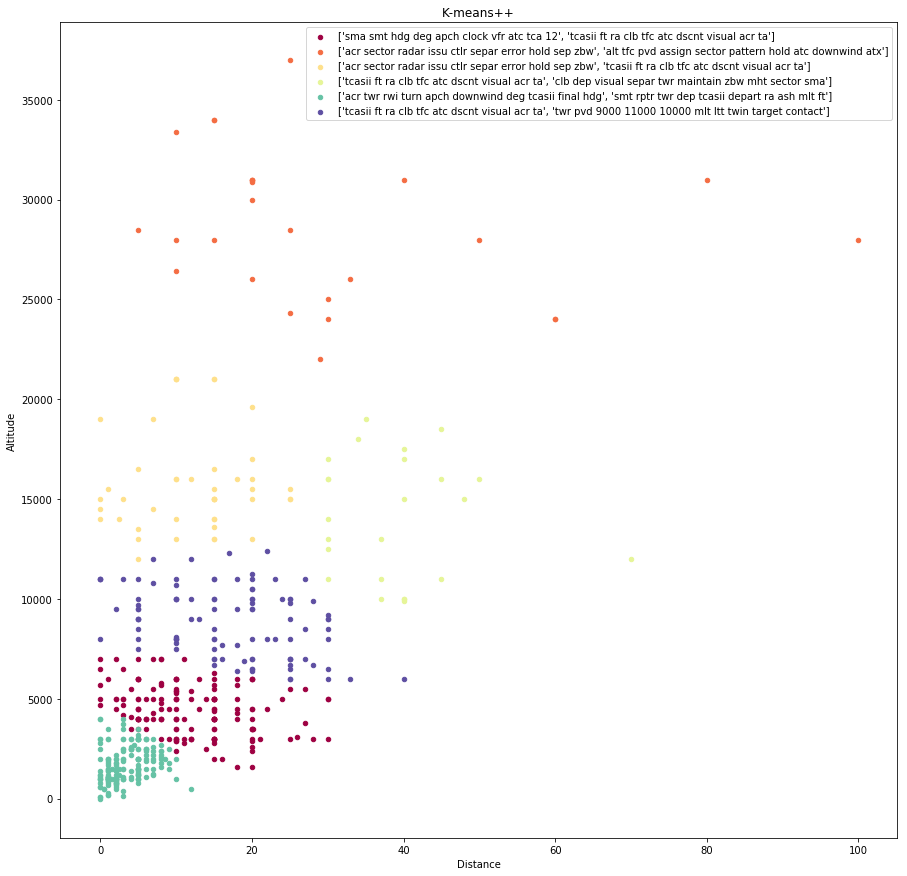

In [18]:
# Re-run k-means++ after excluding the outliers
k = 6
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1)
kmeans.fit_predict(new_features)
Kcentroids = kmeans.cluster_centers_
Klabels = kmeans.labels_
Kerror = kmeans.inertia_
print("The total error of the clustering is: {}.".format(Kerror))

Kasc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
Korder_centroids = Kasc_order_centroids[:,::-1]
Korder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Korder_centroids]) # remove locations

Kcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Korder_centroids[i, :2]]
    Kcluster_names.append(label)
    
# Plot k-means++
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Klabels)) if Klabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, color=colors[cluster_index], label = Kcluster_names[cluster_index], s=20)
    
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('K-means++')
plt.show()

1. Traffic Collision Avoidence System / FT / Radar Advisory Service / Climb / Air Traffic Control / Traffic / Visual / accident / descent / true air speed
2. Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet
3. Aircraft / sector / issue / radar / control / separation / error / holding / sep (single Engine Piston) / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug)
4. aircraft / sma (a type of engine) / traffic / smt (SMT RDL 084 is simply a lead radial, so it is there to let you know when to start your turn) / tower / runaway / approach / clock / hdg (Heading Mode The autopilot keeps the nose of the airplane pointed at the magnetic heading bug) / atc (air traffic control)
5. Traffic / Apching / sector (a portion of an itinerary) / Visual / Control / Bradley International Airport / Boston Air Route Traffic Control Center (ZBW) / climb / jet

The usual flying altitude of an aircraft is 39,000 feet. 
Observation: 
1. The lower the altitude, collision is more likely to happen. 
2. At low altitude collision (< 8,000), from the text analysis we can see they happen with climbing and descent, the parameters which may affect the collision are: true air speed, control of the airplane, heading mode, radar, radar advisory service, visual, and happens frequently among sinle engine piston. 
3. At high altitude collision (8,000 ~ 3,6000), from the text analysis we can see they happen during sector(a portion of an itinerary) or climb, and associates more with the arrangement of the traffic control center and airport, visual may also counts as a factor. 

## Hierarchical

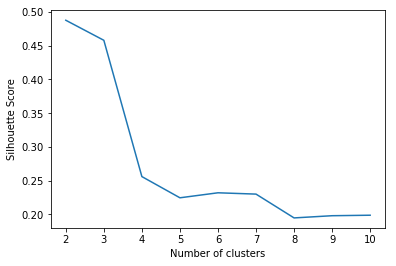

In [19]:
# Find the optimal number of clusters
Z = hierarchy.linkage(new_features, method='ward')
max_clusters = 10
s = np.zeros(max_clusters+1) 

for k in range(2,max_clusters+1):
    clusters = hierarchy.fcluster(Z, k, criterion='maxclust')
    s[k] = metrics.silhouette_score(new_features,clusters,metric='euclidean')
    
plt.plot(range(2,len(s)),s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

From the graph above, we can see that when number of clusters is 4, the silhouette score is the highest beside 2. So we choose cluster number to be 4.

In [20]:
k = 6
euclidean = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean').fit(new_features)
Hlabels = euclidean.labels_

In [21]:
# Find centroids for each cluster
def find_centroids(k, label):
    centroids = []
    for cluster_label in range(k):
        features_list = [new_features.values[index] for index in range(len(label)) if label[index] == cluster_label]
        sum_features = np.sum(features_list, axis=0)
        mean_features = [x/len(features_list) for x in sum_features]
        centroids.append(mean_features)
    return np.array(centroids)
Hcentroids = find_centroids(k, Hlabels)

In [22]:
# Name k Hierarchical clusters
Hasc_order_centroids = Hcentroids.argsort()#[:, ::-1]
Horder_centroids = Hasc_order_centroids[:,::-1]
Horder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Horder_centroids]) # remove locations

Hcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Horder_centroids[i, :2]]
    Hcluster_names.append(label)

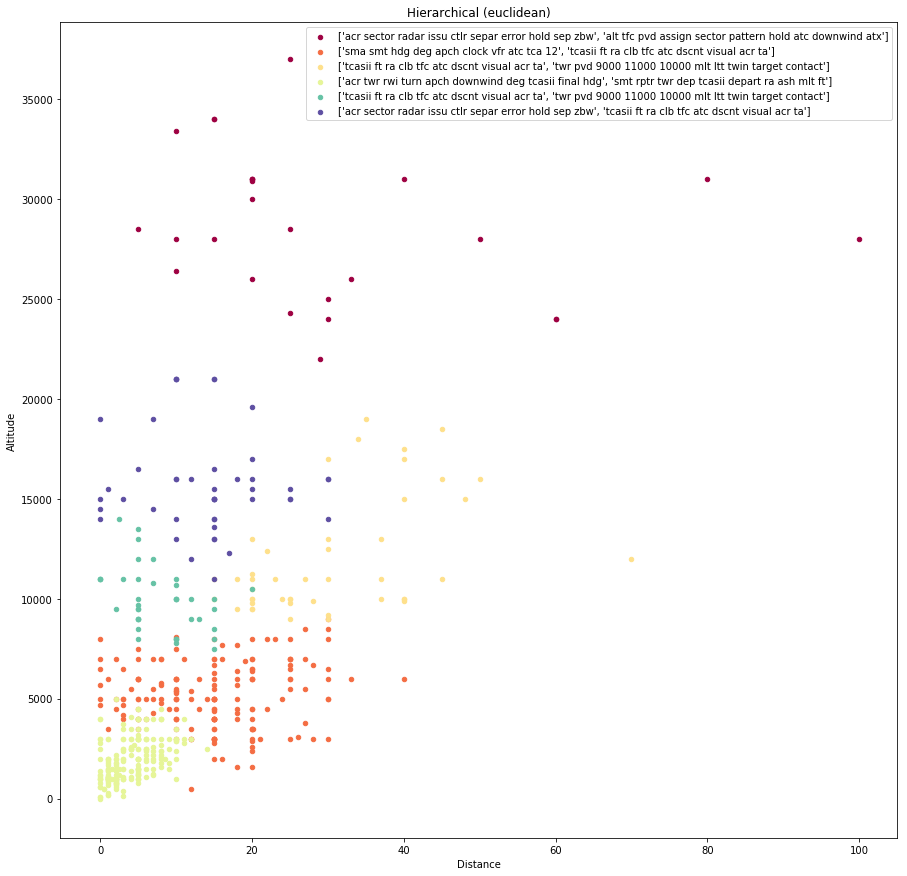

In [23]:
# Plot Hierarchical
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Hlabels)) if Hlabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Hcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('Hierarchical (euclidean)')
plt.show()

## GMM

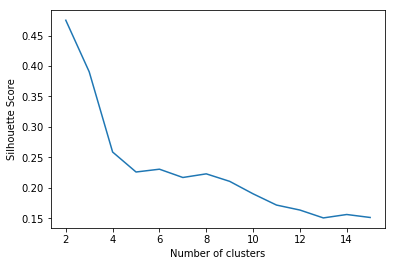

In [24]:
# Find the optimal number of components
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0; 
    for k in range(2,max_clusters+1):
        gmm = mixture.GaussianMixture(n_components=k, covariance_type='spherical')
        gmm.fit(X)
        y_pred = gmm.predict(X)
        s[k] = metrics.silhouette_score(X, y_pred, metric='euclidean')
        
    plt.plot(range(2,len(s)),s[2:]) 
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

sc_evaluate_clusters(new_features, 15)

Based the graph above, we can find that when the number of clusters is 6, the function has the most accurate result beside 2.

In [25]:
k = 6
gmm = mixture.GaussianMixture(n_components=k, covariance_type='spherical')
gmm.fit(new_features)
Gcentroids = gmm.means_
Glabels = gmm.predict(new_features)

In [26]:
# Name k GMM clusters
Gasc_order_centroids = Gcentroids.argsort()#[:, ::-1]
Gorder_centroids = Gasc_order_centroids[:,::-1]
Gorder_centroids = np.array([[x - 2 for x in row if (x - 2) >= 0] for row in Gorder_centroids]) # remove locations

Gcluster_names = []
for i in range(k):
    label = [components[ind] for ind in Gorder_centroids[i, :2]]
    Gcluster_names.append(label)

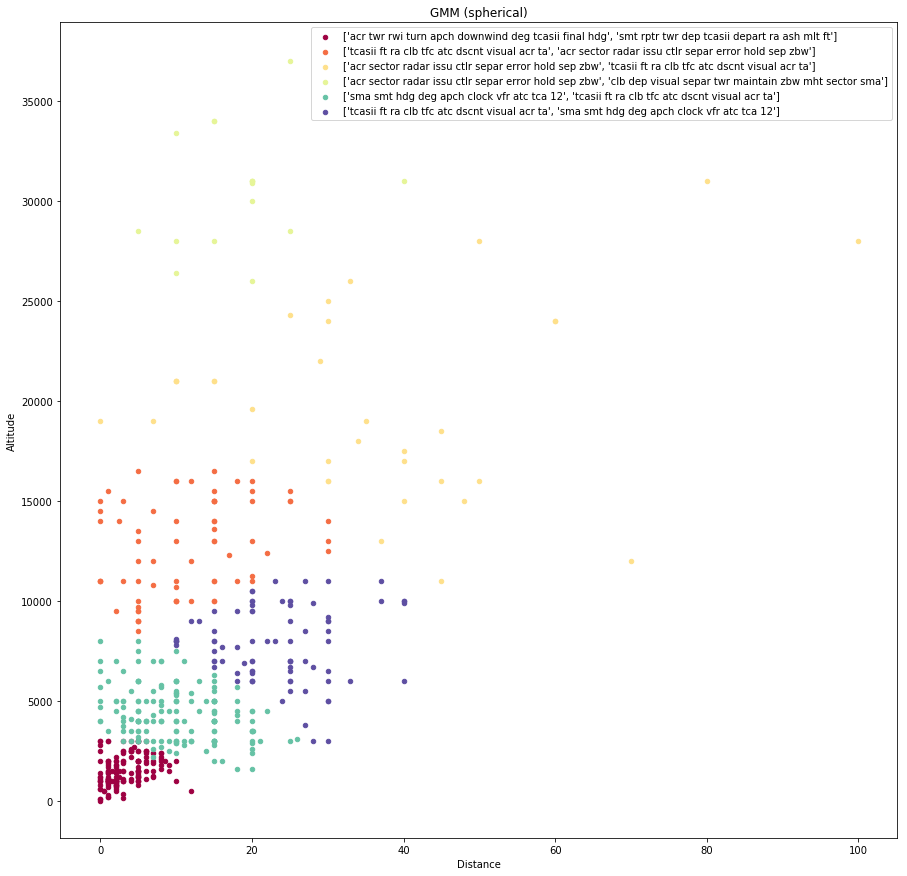

In [27]:
# Plot GMM
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, k)]

for cluster_index in range(k):
    dis = [new_report.iloc[i]['Distance'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    alt = [new_report.iloc[i]['Altitude'] for i in range(len(Glabels)) if Glabels[i] == cluster_index]
    plt.scatter(x=dis, y=alt, c=colors[cluster_index], label = Gcluster_names[cluster_index], s=20)

plt.legend()
plt.xlabel('Distance')
plt.ylabel('Altitude')
plt.title('GMM (spherical)')
plt.show()

# K-means++ Results

In [28]:
# Record the indices of the report in each cluster
Kclusters_reports_index = {}
for i in (range(len(Klabels))):
    if Klabels[i] in Kclusters_reports_index:
        Kclusters_reports_index[Klabels[i]].append(i)
    else:
        Kclusters_reports_index[Klabels[i]] = [i]

In [29]:
# Helper methods for counting the occurrences of each term in a report
from collections import Counter
def count_words_in_report(report):
    counts = Counter(report.split())
    return counts

In [30]:
altitude_ranges = [range(5000), range(5000, 10000), range(10000, 20000), range(20000, 30000), range(30000, 40000)]
altitudes = ['0-10000', '10000-20000', '20000-30000', '30000-40000', '40000-50000']

def cluster_heat_map(i):
    # Initialize a dataframe for counting
    cluster_labels = Kcluster_names[i][0].split() + Kcluster_names[i][1].split()
    df_count = pd.DataFrame(np.zeros((len(altitudes), len(cluster_labels))))
    df_count.index = ['0-10000', '10000-20000', '20000-30000', '30000-40000', '40000-50000']
    df_count.columns = cluster_labels

    # reports in this cluster
    reports_index = Kclusters_reports_index[i]
    for report_index in reports_index:
        altitude = new_report.iloc[report_index]['Altitude']
        report_word_count = Counter(new_report.iloc[report_index]['Report'].split())
        
        for r in range(len(altitude_ranges)):
            if altitude in altitude_ranges[r]:
                for label in cluster_labels:
                    df_count.iloc[r][label] += report_word_count[label]
        # end of altitude ranges
    # end of reports in this cluster

    plt.figure(figsize=(20, 20))
    plt.matshow(df_count.values, cmap=plt.cm.Blues)
    plt.xticks(np.arange(df_count.shape[1]), df_count.columns.tolist(), rotation='vertical')
    plt.yticks(np.arange(df_count.shape[0]), df_count.index.tolist())
    
    print("Cluster index {}".format(i + 1))
    print("Cluster labels {}".format(cluster_labels))
    print(df_count)

Cluster index 1
Cluster labels ['sma', 'smt', 'hdg', 'deg', 'apch', 'clock', 'vfr', 'atc', 'tca', '12', 'tcasii', 'ft', 'ra', 'clb', 'tfc', 'atc', 'dscnt', 'visual', 'acr', 'ta']
              sma   smt   hdg   deg   apch  clock   vfr    atc   tca    12  \
0-10000      36.0  16.0  84.0  96.0  192.0    0.0  57.0  128.0  10.0  23.0   
10000-20000  28.0  25.0  52.0  53.0   60.0    0.0  35.0  116.0  20.0   6.0   
20000-30000   0.0   0.0   0.0   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
30000-40000   0.0   0.0   0.0   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
40000-50000   0.0   0.0   0.0   0.0    0.0    0.0   0.0    0.0   0.0   0.0   

             tcasii   ft   ra   clb    tfc    atc  dscnt  visual   acr   ta  
0-10000       135.0  0.0  0.0  88.0  201.0  128.0   44.0    39.0  68.0  1.0  
10000-20000    68.0  0.0  1.0  59.0  119.0  116.0   36.0    19.0  67.0  0.0  
20000-30000     0.0  0.0  0.0   0.0    0.0    0.0    0.0     0.0   0.0  0.0  
30000-40000     0.0  0.0  0.0   0.0    0

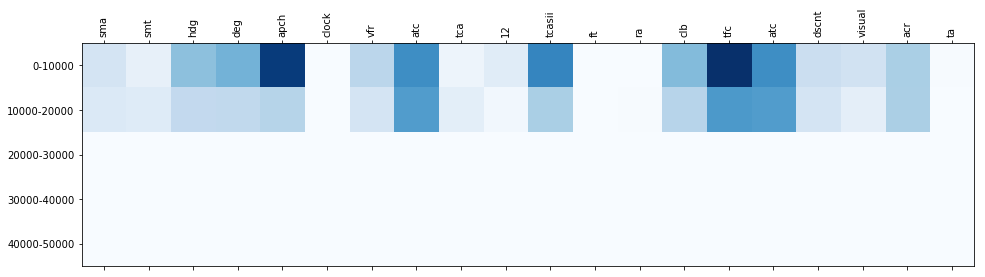

In [31]:
cluster_heat_map(0)

Cluster index 2
Cluster labels ['acr', 'sector', 'radar', 'issu', 'ctlr', 'separ', 'error', 'hold', 'sep', 'zbw', 'alt', 'tfc', 'pvd', 'assign', 'sector', 'pattern', 'hold', 'atc', 'downwind', 'atx']
              acr  sector  radar  issu  ctlr  separ  error  hold  sep   zbw  \
0-10000       0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   
10000-20000   0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   
20000-30000   0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   
30000-40000  39.0    10.0    7.0  10.0  17.0   11.0    4.0  14.0  4.0  12.0   
40000-50000  45.0    96.0   20.0  20.0  21.0   18.0    6.0   8.0  1.0  11.0   

              alt   tfc  pvd  assign  sector  pattern  hold  atc  downwind  \
0-10000       0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0       0.0   
10000-20000   0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0       0.0   
20000-30000   0.0   0.0  0.0     0.0     0.0      0.0   0.0  0.0       0.0   
30000-40000  

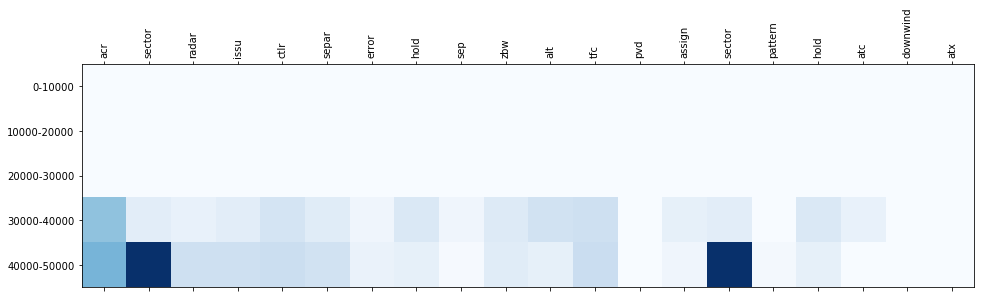

In [32]:
cluster_heat_map(1)

Cluster index 3
Cluster labels ['acr', 'sector', 'radar', 'issu', 'ctlr', 'separ', 'error', 'hold', 'sep', 'zbw', 'tcasii', 'ft', 'ra', 'clb', 'tfc', 'atc', 'dscnt', 'visual', 'acr', 'ta']
               acr  sector  radar  issu  ctlr  separ  error  hold  sep   zbw  \
0-10000        0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   
10000-20000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   
20000-30000  252.0    50.0   36.0  42.0  78.0   60.0   14.0  16.0  6.0  44.0   
30000-40000   22.0     9.0    4.0   4.0   8.0    8.0    2.0   0.0  1.0   1.0   
40000-50000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   0.0  0.0   0.0   

             tcasii   ft   ra   clb    tfc   atc  dscnt  visual    acr   ta  
0-10000         0.0  0.0  0.0   0.0    0.0   0.0    0.0     0.0    0.0  0.0  
10000-20000     0.0  0.0  0.0   0.0    0.0   0.0    0.0     0.0    0.0  0.0  
20000-30000    47.0  1.0  0.0  54.0  113.0  29.0   42.0    38.0  252.0  0.0  
30000-40000     6.

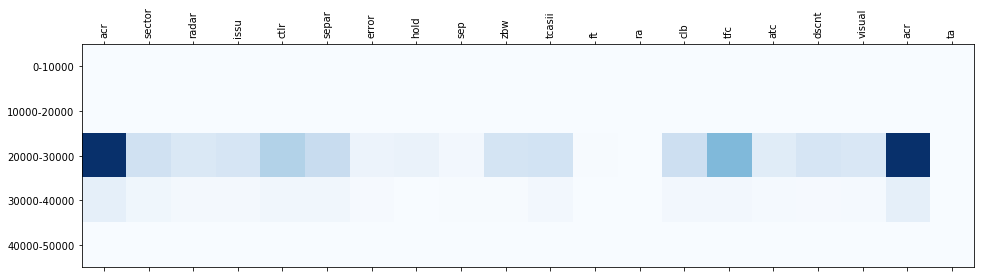

In [33]:
cluster_heat_map(2)

Cluster index 4
Cluster labels ['tcasii', 'ft', 'ra', 'clb', 'tfc', 'atc', 'dscnt', 'visual', 'acr', 'ta', 'clb', 'dep', 'visual', 'separ', 'twr', 'maintain', 'zbw', 'mht', 'sector', 'sma']
             tcasii   ft   ra   clb   tfc   atc  dscnt  visual   acr   ta  \
0-10000         0.0  0.0  0.0   0.0   0.0   0.0    0.0     0.0   0.0  0.0   
10000-20000     0.0  0.0  0.0   0.0   3.0   0.0    1.0     0.0   0.0  0.0   
20000-30000    27.0  0.0  0.0  94.0  62.0  16.0   19.0    74.0  32.0  0.0   
30000-40000     0.0  0.0  0.0   0.0   0.0   0.0    0.0     0.0   0.0  0.0   
40000-50000     0.0  0.0  0.0   0.0   0.0   0.0    0.0     0.0   0.0  0.0   

              clb  dep  visual  separ  twr  maintain   zbw  mht  sector  sma  
0-10000       0.0  0.0     0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0  
10000-20000   0.0  0.0     0.0    0.0  0.0       0.0   0.0  0.0     0.0  0.0  
20000-30000  94.0  8.0    74.0   26.0  0.0      12.0  18.0  5.0     5.0  2.0  
30000-40000   0.0  0.0     0.0 

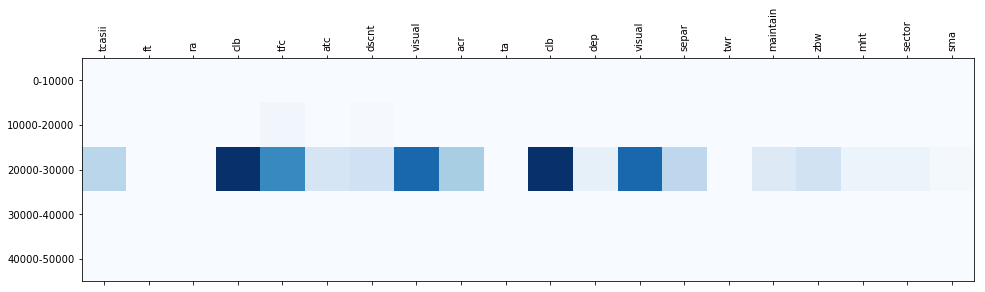

In [34]:
cluster_heat_map(3)

Cluster index 5
Cluster labels ['acr', 'twr', 'rwi', 'turn', 'apch', 'downwind', 'deg', 'tcasii', 'final', 'hdg', 'smt', 'rptr', 'twr', 'dep', 'tcasii', 'depart', 'ra', 'ash', 'mlt', 'ft']
              acr    twr    rwi   turn   apch  downwind    deg  tcasii  final  \
0-10000      86.0  790.0  381.0  378.0  444.0     162.0  195.0   158.0  141.0   
10000-20000   0.0    0.0    0.0    0.0    0.0       0.0    0.0     0.0    0.0   
20000-30000   0.0    0.0    0.0    0.0    0.0       0.0    0.0     0.0    0.0   
30000-40000   0.0    0.0    0.0    0.0    0.0       0.0    0.0     0.0    0.0   
40000-50000   0.0    0.0    0.0    0.0    0.0       0.0    0.0     0.0    0.0   

               hdg   smt  rptr    twr    dep  tcasii  depart   ra   ash   mlt  \
0-10000      133.0  29.0  71.0  790.0  113.0   158.0    99.0  0.0  38.0  10.0   
10000-20000    0.0   0.0   0.0    0.0    0.0     0.0     0.0  0.0   0.0   0.0   
20000-30000    0.0   0.0   0.0    0.0    0.0     0.0     0.0  0.0   0.0   0.0   


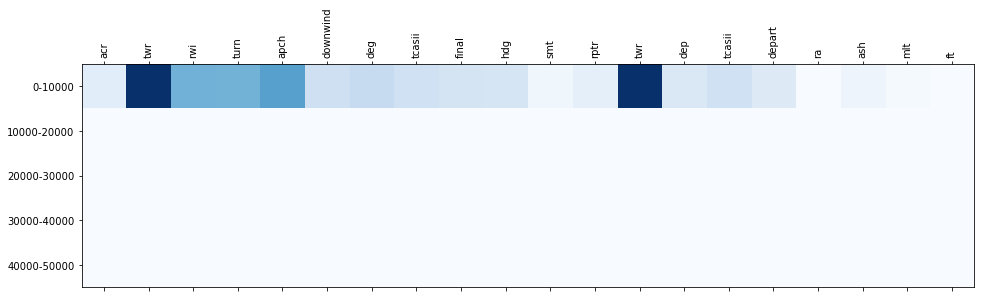

In [35]:
cluster_heat_map(4)

Cluster index 6
Cluster labels ['tcasii', 'ft', 'ra', 'clb', 'tfc', 'atc', 'dscnt', 'visual', 'acr', 'ta', 'twr', 'pvd', '9000', '11000', '10000', 'mlt', 'ltt', 'twin', 'target', 'contact']
             tcasii   ft   ra   clb    tfc   atc  dscnt  visual   acr   ta  \
0-10000         0.0  0.0  0.0   0.0    0.0   0.0    0.0     0.0   0.0  0.0   
10000-20000    97.0  0.0  0.0  66.0  182.0  67.0   51.0    35.0  77.0  0.0   
20000-30000    57.0  0.0  0.0  42.0   72.0  35.0   14.0    22.0  50.0  0.0   
30000-40000     0.0  0.0  0.0   0.0    0.0   0.0    0.0     0.0   0.0  0.0   
40000-50000     0.0  0.0  0.0   0.0    0.0   0.0    0.0     0.0   0.0  0.0   

             twr   pvd  9000  11000  10000  mlt   ltt  twin  target  contact  
0-10000      0.0   0.0   0.0    0.0    0.0  0.0   0.0   0.0     0.0      0.0  
10000-20000  2.0  18.0  46.0   17.0   45.0  0.0  10.0   1.0    23.0     25.0  
20000-30000  0.0  12.0   2.0   32.0   30.0  1.0   9.0   8.0    19.0     11.0  
30000-40000  0.0   0.0   

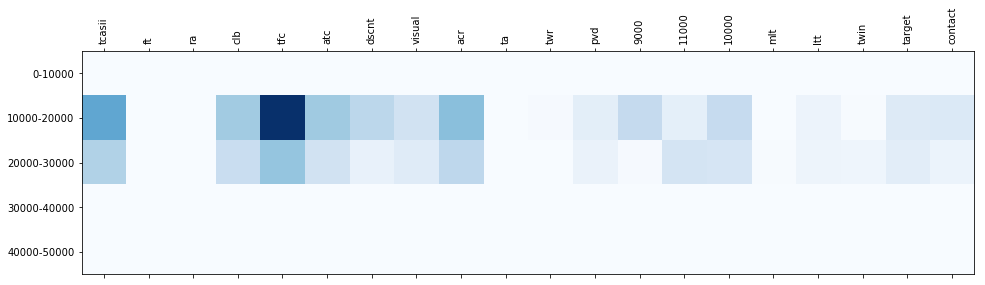

In [36]:
cluster_heat_map(5)

## Analysis

### Latent Semantic Analysis
##### Parameters
- Explain deciding n_components
- scale location (we do not want the location vectors to be too dominant to make the text features meaningless)

##### Full forms of the above abbreviations
Full forms of the above abbreviations:
1. 
2. 
3. 
4.
5.
1. aircaft, error, standard, system, separation, between, Less Than Standard Separation
2. control, boston air route traffic control center, experience, operator, at, separation, standard, feet
3. Traffic Alert and Collision Avoidance, to, alert, aircaft, Resolution Advisory, Less Than Standard Separation, assign, descdent
4. runways, on, aircraft, approach, experience, Less Than Standard Separation, operator, error
5. Resolution Advisory, Traffic Alert and Collision Avoidance, report, crew, aircraft, approach runway, control

1. Near mid air collision, , , Pattern
2. aircraft, error, standard, Near mid air collision,
3. separate, 
4.
5.

### Clustering
##### Parameters
Explain Some variable we play around with:
- k number of clusters

##### Results
1. midair collision sma has pattern / less than standard separation system error oppuacied
2. aircarrier error standard midair collision / in separate standard aircraft
3. nmac operator

##### K-means, Hierarchical and GMM